# Unsupervised learning for data clustering

## Global settings

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import confusion_matrix

In [22]:
class AnomalyPlotter():
    def __init__(self, data, true_label, predicted_label): 
        # Omit extreme data points
        data = data.loc[data['temperature'] > -50]
        self.data = data
        self.data_tp = data.loc[(data[true_label] == 1) & data[predicted_label] == 1]
        self.data_tn = data.loc[(data[true_label] == 0) & data[predicted_label] == 0]
        self.data_fp = data.loc[(data[true_label] == 1) & data[predicted_label] == 0]
        self.data_fn = data.loc[(data[true_label] == 0) & data[predicted_label] == 1]
        
        self.data_normal = data.loc[data[true_label] == 0]
        self.data_abnormal = data.loc[data[true_label] == 1]
        self.data_pred_normal = data.loc[data[predicted_label] == 0]
        self.data_pred_abnormal = data.loc[data[predicted_label] == 1]
        
    def plot_anomalies(self, feature, ax): 
        self.data_normal.plot.scatter(x='id', y=feature, s=4, c='green', figsize=(16, 9), alpha=0.5, ax=ax[0], label='True Normal')
        self.data_abnormal.plot.scatter(x='id', y=feature, s=4, c='red', alpha=0.5, ax=ax[0], label='True Abnormal')
        self.data_pred_normal.plot.scatter(x='id', y=feature, s=4, c='green', alpha=0.5, ax=ax[1], label='Predicted Normal')
        self.data_pred_abnormal.plot.scatter(x='id', y=feature, s=4, c='red', alpha=0.5, ax=ax[1], label='Predicted Abnormal')
        return ax
        
    def plot_corr(self, feature1, feature2, ax): 
        self.data_normal.plot.scatter(x=feature1, y=feature2, s=4, c='green', figsize=(16, 9), alpha=0.5, ax=ax[0], label='True normal')
        self.data_abnormal.plot.scatter(x=feature1, y=feature2, s=4, c='red', alpha=0.5, ax=ax[0], label='True Abnormal')
        self.data_pred_normal.plot.scatter(x=feature1, y=feature2, s=4, c='green', alpha=0.5, ax=ax[1], label='Predicted Normal')
        self.data_pred_abnormal.plot.scatter(x=feature1, y=feature2, s=4, c='red', alpha=0.5, ax=ax[1], label='Predicted Abnormal')
        return ax

        
    def plot_pred_anomalies(self, feature, ax):
        ''' Plot the predicted anomalies.
        '''
        self.data_fp.plot.scatter(x='id', y=feature, s=4, c='orange', figsize=(16, 9), alpha=0.5, ax=ax, label='False Positive')
        self.data_fn.plot.scatter(x='id', y=feature, s=4, c='red', alpha=0.5, ax=ax, label='False Negative')
        self.data_tn.plot.scatter(x='id', y=feature, s=4, c='blue', alpha=0.5, ax=ax, label='True Negative')
        self.data_tp.plot.scatter(x='id', y=feature, s=4, c='green', alpha=0.5, ax=ax, label='True Positive')
        return ax
    
    def plot_pred_corr(self, feature1, feature2, ax): 
        ''' Plot the predicted results along two dimensions
        '''
        self.data_fp.plot.scatter(x=feature1, y=feature2, s=4, c='orange', figsize=(8, 8), alpha=0.5, ax=ax, label='False Positive')
        self.data_fn.plot.scatter(x=feature1, y=feature2, s=4, c='red', alpha=0.5, ax=ax, label='False Negative')
        self.data_tn.plot.scatter(x=feature1, y=feature2, s=4, c='blue', alpha=0.5, ax=ax, label='True Negative')
        self.data_tp.plot.scatter(x=feature1, y=feature2, s=4, c='green', alpha=0.5, ax=ax, label='True Positive')
        return ax


In [4]:
DATA_PATH = "data/2010to2017nsWithoutNA.csv"

In [5]:
data = pd.read_csv(DATA_PATH)
# Add id 
data['id'] = range(len(data))
data.head()

,time,Longitude,Latitude,botDepth,date,depth,temperature,salinity,qualityflag,id
0,15.0,9.65706,53.57080,12.0,20100121.0,3.0,0.0005,33.658676,0.0,0
1,15.0,9.65226,53.57170,11.0,20100121.0,3.0,0.0026,33.658894,0.0,1
2,15.0,9.64802,53.57256,13.0,20100121.0,3.0,0.0015,33.658823,0.0,2
3,15.0,9.64354,53.57392,12.0,20100121.0,3.0,0.0018,33.658896,0.0,3
4,15.0,9.63918,53.57548,13.0,20100121.0,3.0,0.0010,33.658877,0.0,4


## K-means

In [6]:
input_data = data.drop(columns=['id', 'qualityflag'])
input_data.head()

,time,Longitude,Latitude,botDepth,date,depth,temperature,salinity
0,15.0,9.65706,53.57080,12.0,20100121.0,3.0,0.0005,33.658676
1,15.0,9.65226,53.57170,11.0,20100121.0,3.0,0.0026,33.658894
2,15.0,9.64802,53.57256,13.0,20100121.0,3.0,0.0015,33.658823
3,15.0,9.64354,53.57392,12.0,20100121.0,3.0,0.0018,33.658896
4,15.0,9.63918,53.57548,13.0,20100121.0,3.0,0.0010,33.658877


In [26]:
input_data = data[['temperature', 'salinity']]
input_data.head()

,temperature,salinity
0,0.0005,33.658676
1,0.0026,33.658894
2,0.0015,33.658823
3,0.0018,33.658896
4,0.0010,33.658877


In [29]:
# Apply k-Means
kmean = KMeans(n_clusters=2)
kmean.fit(input_data)
label = kmean.predict(input_data)
data['kmeans_label'] = label
data.head()

,time,Longitude,Latitude,botDepth,date,depth,temperature,salinity,qualityflag,id,kmeans_label
0,15.0,9.65706,53.57080,12.0,20100121.0,3.0,0.0005,33.658676,0.0,0,1
1,15.0,9.65226,53.57170,11.0,20100121.0,3.0,0.0026,33.658894,0.0,1,1
2,15.0,9.64802,53.57256,13.0,20100121.0,3.0,0.0015,33.658823,0.0,2,1
3,15.0,9.64354,53.57392,12.0,20100121.0,3.0,0.0018,33.658896,0.0,3,1
4,15.0,9.63918,53.57548,13.0,20100121.0,3.0,0.0010,33.658877,0.0,4,1


In [ ]:
# silhouette_score(input_data, label)

In [30]:
# TP, TN, FN, TP
evaluation = pd.DataFrame()
evaluation['id'] = data['id']
evaluation['true_label'] = data['qualityflag']
evaluation['predicted_label'] = label

cm = confusion_matrix(evaluation['true_label'], evaluation['predicted_label'])
cm

array([[ 94019, 125060],
       [  1048,    485]])

In [31]:
TN, FP, FN, TP = cm.ravel()
(TN, FP, FN, TP)

(94019, 125060, 1048, 485)

In [32]:
# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)

# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)

In [33]:
ACC 

0.42837198339165594

In [48]:
# Save predicted labels and metrics
data.to_csv('results/kmeans.csv')

In [65]:
# Save the new result
new_result = {
    'method': 'kmeans', 
    'TPR': TPR, 
    'TNR': TNR, 
    'FPR': FPR, 
    'FNR': FNR, 
    'Precision': PPV, 
    'Recall': TPR
}
new_result = pd.DataFrame(new_result, index=[0])

try: 
    result_metrics = pd.read_csv('results/result_metrics.csv')
    result_metrics = pd.concat([result_metrics, new_result])
except: 
    print('Create new result file.')
    result_metrics = new_result
result_metrics.to_csv('results/result_metrics.csv', index=False)

array([<AxesSubplot: xlabel='temperature', ylabel='salinity'>,
       <AxesSubplot: xlabel='temperature', ylabel='salinity'>],
      dtype=object)

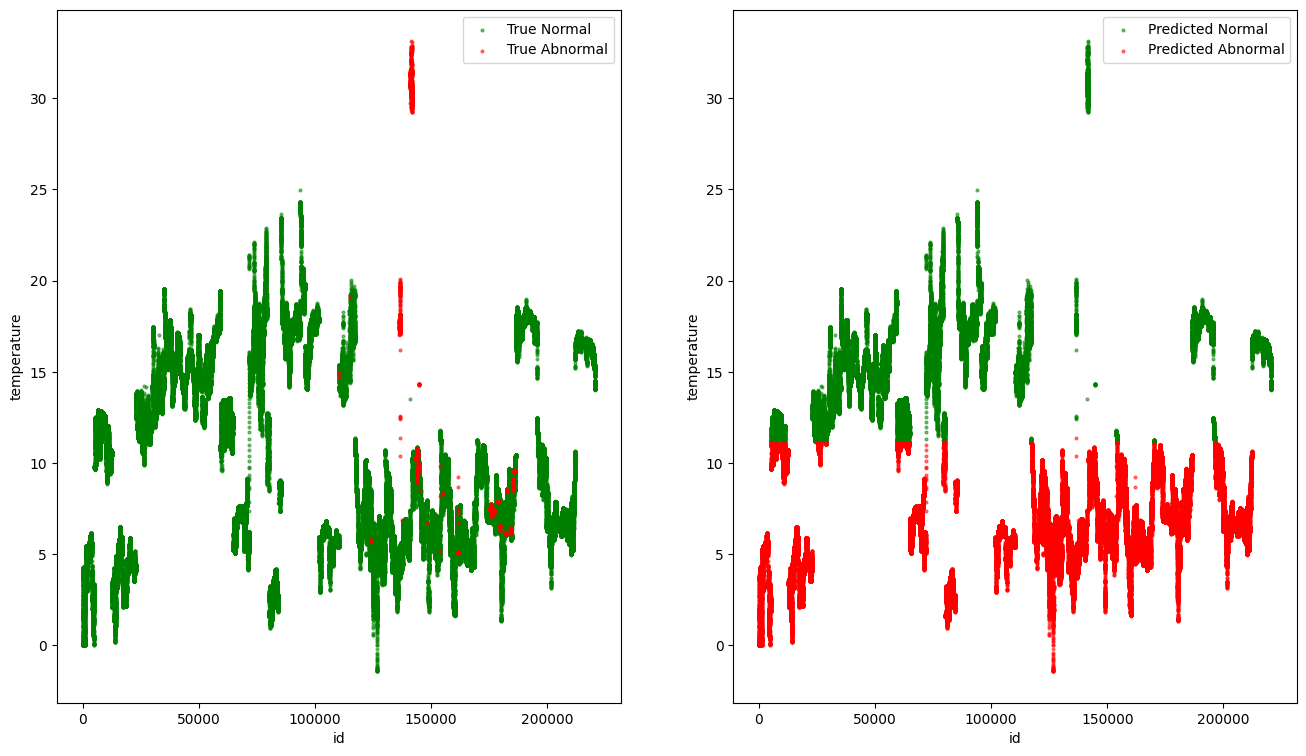

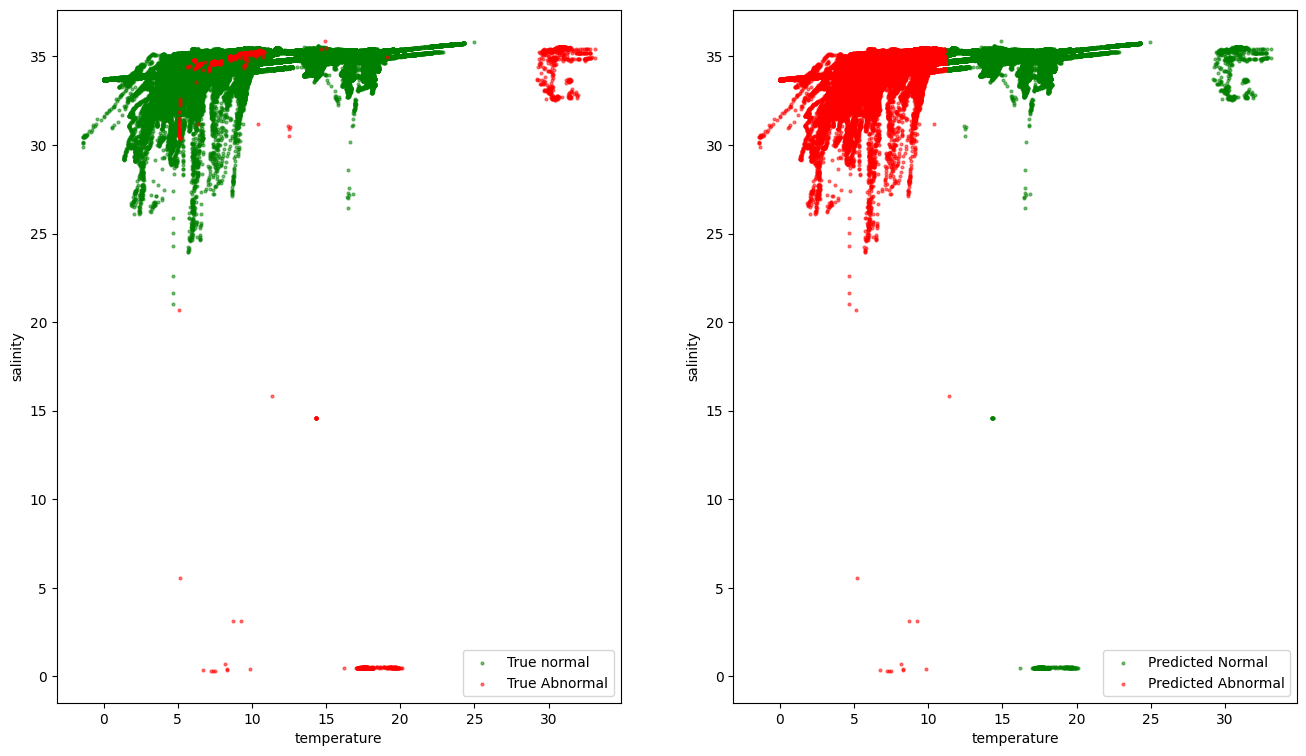

In [34]:
true_label='qualityflag'
predicted_label='kmeans_label'
plotter = AnomalyPlotter(data, true_label, predicted_label)

feature = 'temperature'
feature1 = 'temperature'
feature2 = 'salinity'

fig, ax = plt.subplots(1, 2)
plotter.plot_anomalies(feature, ax)  

fig, ax = plt.subplots(1, 2)
plotter.plot_corr(feature1, feature2, ax)            